In [1]:
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import model_bs as mdl
import data_utils as du
import dataset as ds

token_to_idx, idx_to_token = du.load_or_create_vocabulary(csv_paths=[], cache_path="/home/mmondol/VAE_LLM/LSTM_VAE_Paper/vocab.json",test_smiles=None)

assert token_to_idx["<PAD>"] == 0
assert token_to_idx["<SOS>"] == 2
assert token_to_idx["<EOS>"] == 3

model = mdl.LSTM_VAE_Trans(
        vocab_size=len(token_to_idx),
        d_model=256,
        latent_dim=64,
        pad_idx=0,
        sos_idx=2,
        eos_idx=3,
        enc_layers=7,
        dec_layers=7,
        nhead=8,
        dropout=0.05,
        max_len=160,
        dim_feedforward=1024)
model.load_state_dict(torch.load("/home/mmondol/VAE_LLM/LSTM_VAE_Paper/checkpoints/best_model.pth", map_location="cpu"))

# unwrap DataParallel if needed, and get device
m = model.module if isinstance(model, nn.DataParallel) else model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
m = model  # (no DP wrapping here)
m.eval()

[vocab] loaded cached vocabulary from /home/mmondol/VAE_LLM/LSTM_VAE_Paper/vocab.json (69 tokens)


/tmp/ipykernel_204622/2622478459.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/mmondol/VAE_LLM/LSTM_VAE_Paper/checkpoints/best

LSTM_VAE_Trans(
  (encoder): EncoderBiLSTM(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (emb_do): Dropout(p=0.1, inplace=False)
    (lstm): LSTM(256, 128, num_layers=7, batch_first=True, dropout=0.05, bidirectional=True)
    (out_do): Dropout(p=0.05, inplace=False)
    (seq_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pool_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (to_mu): Linear(in_features=256, out_features=64, bias=True)
  (to_logvar): Linear(in_features=256, out_features=64, bias=True)
  (latent_to_token): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (emb): Embedding(69, 256, padding_idx=0)
    (emb_ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pe): PositionalEncoding(
      (dropout): Dropout(p=0.05, inplace=False)
    )

In [2]:
# Example configuration dictionary
cfg = {"test_files": ["/home/mmondol/VAE_LLM/Data/union.csv"], "seq_length": 160, "latent_dim": 64}
smiles = du.load_smiles_list([cfg["test_files"][0]], n_samples=18000, shuffle=False)
test_ds = ds.SMILESDataset(smiles, seq_length=cfg["seq_length"], token_to_idx=token_to_idx,augmentor=None, augment_train=False)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

In [3]:
latents = []
with torch.no_grad():
    for inp, tgt in test_dl:                 # dataset returns (seq, seq)
        inp, tgt = inp.to(device), tgt.to(device)
        # forward with TF returns (logits, mu, logvar)
        _, mu, _ = m(inp, tgt=tgt, teacher_forcing=True)
        latents.append(mu.cpu().numpy())

Z = np.concatenate(latents, axis=0)          # [N, latent_dim]
print("Latents shape:", Z.shape)

/home/mmondol/anaconda3/envs/chemoinf/lib/python3.12/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Latents shape: (18000, 64)


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, QED
import numpy as np
import pandas as pd

def props_from_smiles(s):
    m = Chem.MolFromSmiles(s)
    if m is None:
        return None
    return dict(
        MW=Descriptors.MolWt(m),
        LogP=Descriptors.MolLogP(m),
        TPSA=rdMolDescriptors.CalcTPSA(m),
        HBA=rdMolDescriptors.CalcNumHBA(m),
        HBD=rdMolDescriptors.CalcNumHBD(m),
        AromRings=rdMolDescriptors.CalcNumAromaticRings(m),
        RotBonds=rdMolDescriptors.CalcNumRotatableBonds(m),
        HeavyAtoms=m.GetNumHeavyAtoms(),
        Fsp3=rdMolDescriptors.CalcFractionCSP3(m),
        QED=QED.qed(m))

prop_rows = []
for s in smiles:
    d = props_from_smiles(s)
    prop_rows.append(d)

prop_df = pd.DataFrame(prop_rows)

In [5]:
valid_mask = prop_df.notna().all(axis=1).values
Z_ok = Z[valid_mask]
smiles_ok = [s for s, keep in zip(smiles, valid_mask) if keep]
props_ok = prop_df.loc[valid_mask].reset_index(drop=True)
print("Kept:", len(smiles_ok), "of", len(smiles))

Kept: 18000 of 18000


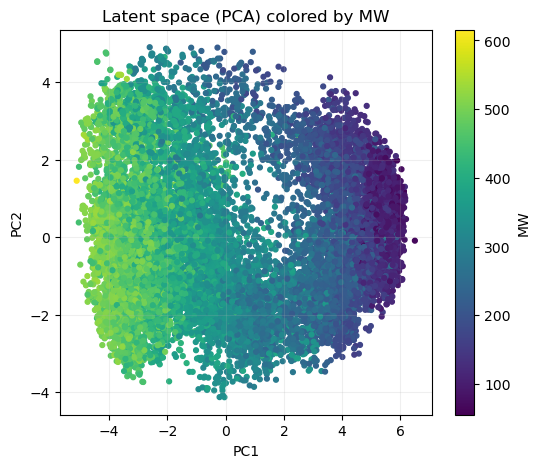

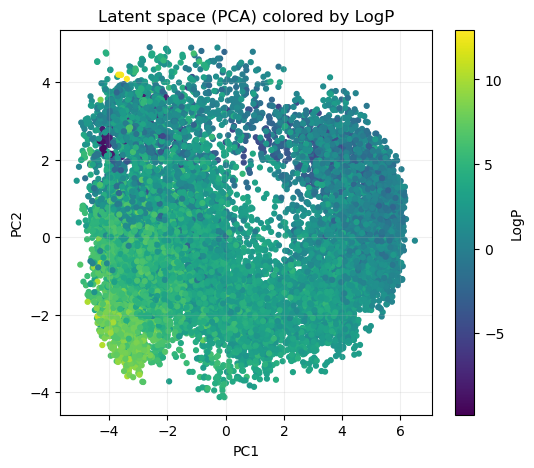

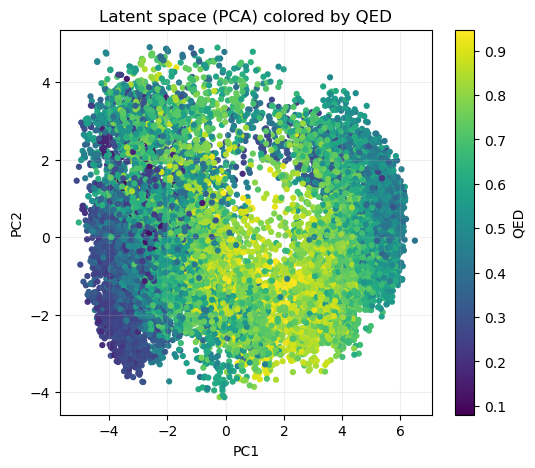

In [6]:
from sklearn.decomposition import PCA
XY = PCA(n_components=2).fit_transform(Z_ok)

def scatter_by(colname):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(XY[:,0], XY[:,1], c=props_ok[colname].values, s=12, cmap="viridis")
    plt.colorbar(sc, label=colname)
    plt.title(f"Latent space (PCA) colored by {colname}")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(alpha=0.2); plt.show()

# Try a few:
for col in ["MW", "LogP", "QED"]:
    scatter_by(col)

In [7]:
# ==== Multi-output property head + Ridge baseline (same split/scalers) ====
PROPS = ["AromRings", "MW", "LogP", "Fsp3", "QED"]
LATENT_DIM = Z_ok.shape[1]
CKPT_PATH = "/home/mmondol/VAE_LLM/LSTM_VAE_Paper/checkpoints/property_head_best.pt"

import numpy as np, pandas as pd, torch
import torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

# 1) Build Y (targets) and one shared split
Y = props_ok[PROPS].values.astype(np.float32)
X_tr, X_va, Y_tr, Y_va = train_test_split(Z_ok, Y, test_size=0.2, random_state=0)

# 2) Standardize X & Y with train stats only (NO leakage)
X_mu = X_tr.mean(axis=0, keepdims=True); X_sd = X_tr.std(axis=0, keepdims=True) + 1e-8
Y_mu = Y_tr.mean(axis=0, keepdims=True); Y_sd = Y_tr.std(axis=0, keepdims=True) + 1e-8

Xtr = (X_tr - X_mu) / X_sd
Xva = (X_va - X_mu) / X_sd

# For MLP training we keep Y standardized (stable optimization)
Ytr_std = (Y_tr - Y_mu) / Y_sd
Yva_std = (Y_va - Y_mu) / Y_sd

Xt = torch.tensor(Xtr, dtype=torch.float32, device=device)
Xv = torch.tensor(Xva, dtype=torch.float32, device=device)
Yt = torch.tensor(Ytr_std, dtype=torch.float32, device=device)
Yv = torch.tensor(Yva_std, dtype=torch.float32, device=device)

# ------------------------------------------------------------------------
# A) Ridge baseline (multi-output)
# ------------------------------------------------------------------------
# Fit on standardized X, predict Y in ORIGINAL units (directly)
ridge = Ridge(alpha=1.0, random_state=0)  # random_state ignored by Ridge but harmless
ridge.fit(Xtr, Y_tr)                      # Y_tr is original units
Yva_pred_ridge = ridge.predict(Xva)       # original units

ridge_rows = []
for i, name in enumerate(PROPS):
    mae = mean_absolute_error(Y_va[:, i], Yva_pred_ridge[:, i])
    r2  = r2_score(Y_va[:, i], Yva_pred_ridge[:, i])
    ridge_rows.append((name, mae, r2))
ridge_df = pd.DataFrame(ridge_rows, columns=["property", "MAE_ridge", "R2_ridge"]).sort_values("R2_ridge", ascending=False)

# ------------------------------------------------------------------------
# B) MLP property head (your working code)
# ------------------------------------------------------------------------
class PropertyHead(nn.Module):
    def __init__(self, in_dim, hidden1=128, hidden2=64, out_dim=5, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(hidden1, hidden2), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(hidden2, out_dim),
        )
    def forward(self, x):
        return self.net(x)

prop_head = PropertyHead(LATENT_DIM, out_dim=len(PROPS)).to(device)

opt = optim.AdamW(prop_head.parameters(), lr=3e-3, weight_decay=2e-4)
loss_fn = nn.MSELoss()

EPOCHS = 1000
patience = 50
print_every = 25

best_val = float("inf")
best_state = None
epochs_no_improve = 0

print(f"Training MLP property head for {EPOCHS} epochs (early stop patience={patience})")
for ep in range(1, EPOCHS + 1):
    # Train
    prop_head.train()
    opt.zero_grad()
    pred_tr = prop_head(Xt)
    loss_tr = loss_fn(pred_tr, Yt)
    loss_tr.backward()
    opt.step()

    # Validate (in standardized Y space)
    prop_head.eval()
    with torch.no_grad():
        pred_va = prop_head(Xv)
        loss_va = loss_fn(pred_va, Yv).item()

    # Track best
    if loss_va < best_val - 1e-7:
        best_val = loss_va
        epochs_no_improve = 0
        best_state = {k: v.detach().cpu().clone() for k, v in prop_head.state_dict().items()}
    else:
        epochs_no_improve += 1

    # Logging
    if ep % print_every == 0 or ep == 1:
        print(f"[{ep:04d}] train MSE: {loss_tr.item():.6f} | val MSE: {loss_va:.6f} | best: {best_val:.6f}")

    # Early stop
    if epochs_no_improve >= patience:
        print(f"[Early stop] at epoch {ep}. Best val MSE: {best_val:.6f}")
        break

# Restore best weights
if best_state is not None:
    prop_head.load_state_dict(best_state)

# Final validation metrics for MLP (in original units)
prop_head.eval()
with torch.no_grad():
    yv_std_pred = prop_head(Xv).cpu().numpy()  # standardized predictions

Yva_pred_mlp = yv_std_pred * Y_sd + Y_mu       # de-standardize to original units

mlp_rows = []
for i, name in enumerate(PROPS):
    mae = mean_absolute_error(Y_va[:, i], Yva_pred_mlp[:, i])
    r2  = r2_score(Y_va[:, i], Yva_pred_mlp[:, i])
    mlp_rows.append((name, mae, r2))
mlp_df = pd.DataFrame(mlp_rows, columns=["property", "MAE_mlp", "R2_mlp"]).sort_values("R2_mlp", ascending=False)

# ------------------------------------------------------------------------
# C) Side-by-side comparison table
# ------------------------------------------------------------------------
cmp = ridge_df.merge(mlp_df, on="property", how="inner")
# reorder columns nicely
cmp = cmp[["property", "MAE_ridge", "R2_ridge", "MAE_mlp", "R2_mlp"]].sort_values("R2_mlp", ascending=False)
display(cmp)

print("Ridge averages →",
      " MAE:", float(np.mean(cmp["MAE_ridge"])),
      " R2:",  float(np.mean(cmp["R2_ridge"])))

print("MLP averages →",
      " MAE:", float(np.mean(cmp["MAE_mlp"])),
      " R2:",  float(np.mean(cmp["R2_mlp"])))

# ------------------------------------------------------------------------
# D) Save checkpoint (MLP head + scalers + metrics + ridge alpha)
# ------------------------------------------------------------------------
ckpt = {
    "model_state": prop_head.state_dict(),
    "x_mu": torch.tensor(X_mu, dtype=torch.float32),
    "x_sd": torch.tensor(X_sd, dtype=torch.float32),
    "y_mu": torch.tensor(Y_mu, dtype=torch.float32),
    "y_sd": torch.tensor(Y_sd, dtype=torch.float32),
    "props": PROPS,
    "latent_dim": LATENT_DIM,
    "arch": {"hidden1": 128, "hidden2": 64, "p_drop": 0.1},
    "best_val_mse_stdspace": float(best_val),  # standardized Y-space
    "val_metrics_mlp": {k: {"MAE": float(mae), "R2": float(r2)} for k, mae, r2 in mlp_rows},
    "val_metrics_ridge": {k: {"MAE": float(mae), "R2": float(r2)} for k, mae, r2 in ridge_rows},
    "ridge_alpha": float(ridge.alpha),
}
torch.save(ckpt, CKPT_PATH)
print(f"Saved best MLP head + scalers + metrics (+ Ridge baseline) to:\n  {CKPT_PATH}")

Training MLP property head for 1000 epochs (early stop patience=50)
[0001] train MSE: 0.997453 | val MSE: 0.918623 | best: 0.918623
[0025] train MSE: 0.208160 | val MSE: 0.173608 | best: 0.173608
[0050] train MSE: 0.141891 | val MSE: 0.116769 | best: 0.116769
[0075] train MSE: 0.118665 | val MSE: 0.095727 | best: 0.095727
[0100] train MSE: 0.105022 | val MSE: 0.084795 | best: 0.084795
[0125] train MSE: 0.097226 | val MSE: 0.077742 | best: 0.077742
[0150] train MSE: 0.090117 | val MSE: 0.072781 | best: 0.072781
[0175] train MSE: 0.085528 | val MSE: 0.069326 | best: 0.069326
[0200] train MSE: 0.080792 | val MSE: 0.066494 | best: 0.066494
[0225] train MSE: 0.078532 | val MSE: 0.064108 | best: 0.064108
[0250] train MSE: 0.075281 | val MSE: 0.062105 | best: 0.062105
[0275] train MSE: 0.072408 | val MSE: 0.060318 | best: 0.060316
[0300] train MSE: 0.070492 | val MSE: 0.058974 | best: 0.058945
[0325] train MSE: 0.069042 | val MSE: 0.057332 | best: 0.057332
[0350] train MSE: 0.066754 | val MSE

,property,MAE_ridge,R2_ridge,MAE_mlp,R2_mlp
1,AromRings,0.269586,0.944912,0.139477,0.983945
0,MW,21.409096,0.950802,14.883557,0.974980
2,Fsp3,0.086169,0.812021,0.031294,0.972219
3,LogP,0.997797,0.740747,0.510596,0.925798
4,QED,0.089337,0.660482,0.039756,0.918059


Ridge averages →  MAE: 4.570396895706653  R2: 0.8217928051948548
MLP averages →  MAE: 3.120936093479395  R2: 0.9550001740455627
Saved best MLP head + scalers + metrics (+ Ridge baseline) to:
  /home/mmondol/VAE_LLM/LSTM_VAE_Paper/checkpoints/property_head_best.pt


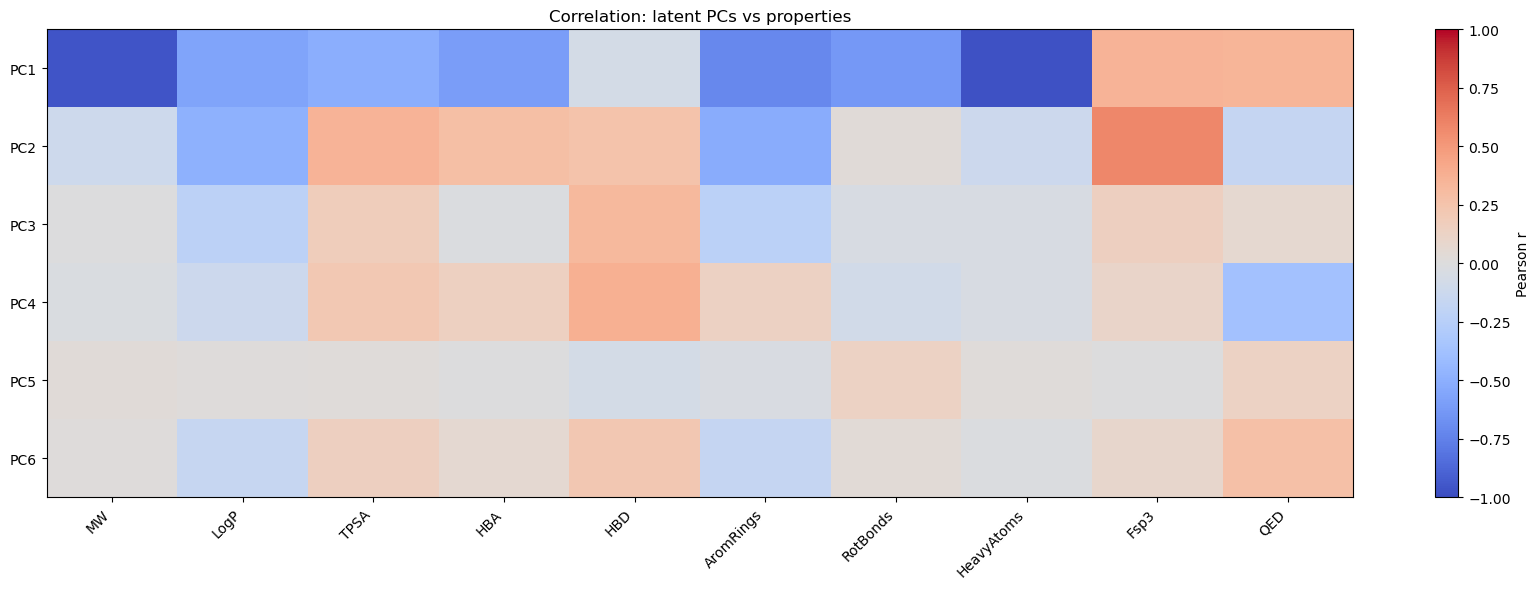

In [8]:
# PCs of Z
pca_full = PCA(n_components=min(20, Z_ok.shape[1]))
Z_pc = pca_full.fit_transform(Z_ok)[:, :6]   # first 6 PCs
pc_df = pd.DataFrame(Z_pc, columns=[f"PC{i+1}" for i in range(Z_pc.shape[1])])

corr = pd.concat([pc_df, props_ok.reset_index(drop=True)], axis=1).corr().loc[pc_df.columns, props_ok.columns]

plt.figure(figsize=(1.5*len(props_ok.columns)+2, 6))
im = plt.imshow(corr.values, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Pearson r")
plt.yticks(range(len(pc_df.columns)), pc_df.columns)
plt.xticks(range(len(props_ok.columns)), props_ok.columns, rotation=45, ha="right")
plt.title("Correlation: latent PCs vs properties")
plt.tight_layout(); plt.show()

Explained variance PC1: 0.2383173
Explained variance PC2: 0.059776757
Explained variance PC1+PC2: 0.29809406
Explained variance first 10 PCs: 0.55047023


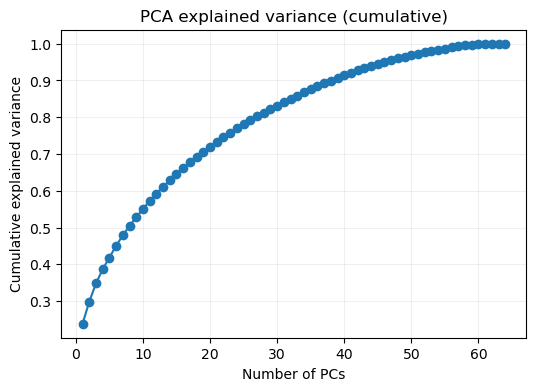

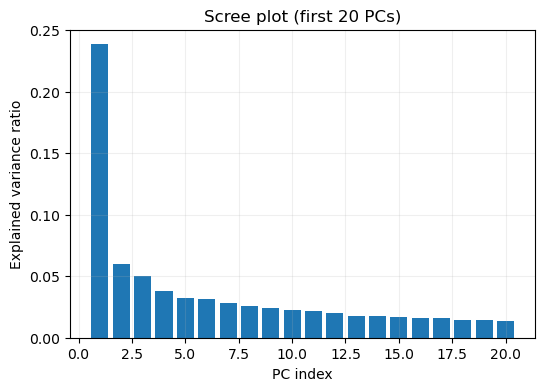

In [9]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca_full = PCA(n_components=min(64, Z_ok.shape[1]))
pca_full.fit(Z_ok)

evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

print("Explained variance PC1:", evr[0])
print("Explained variance PC2:", evr[1])
print("Explained variance PC1+PC2:", evr[0] + evr[1])
print("Explained variance first 10 PCs:", cum[9])

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(evr)+1), cum, marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance (cumulative)")
plt.grid(alpha=0.2)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(np.arange(1, 21), evr[:20])
plt.xlabel("PC index")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot (first 20 PCs)")
plt.grid(alpha=0.2)
plt.show()

In [10]:
import torch
import numpy as np

@torch.no_grad()
def decode_from_z_greedy(m, z, max_len=160):
    """
    Greedy decode SMILES from a given latent vector z.
    z: (latent_dim,) or (B, latent_dim) numpy array or torch tensor
    returns: LongTensor [B, T] token ids (NO <SOS>, stops at <EOS> if produced)
    """
    m.eval()
    device = next(m.parameters()).device

    if isinstance(z, np.ndarray):
        z = torch.from_numpy(z)
    z = z.to(device).float()
    if z.dim() == 1:
        z = z.unsqueeze(0)

    # Build transformer "memory" from z exactly like training
    z_tok = m.latent_to_token(z).unsqueeze(1)  # [B, 1, d_model]
    mem_pad = torch.zeros(z_tok.size(0), 1, dtype=torch.bool, device=device)

    B = z_tok.size(0)
    ys = torch.full((B, 1), m.sos_idx, dtype=torch.long, device=device)

    out = []
    for _ in range(max_len):
        logits = m.decoder(ys, z_tok, mem_pad)              # [B, t, V]
        nxt = logits[:, -1].argmax(dim=-1, keepdim=True)    # [B, 1]
        ys = torch.cat([ys, nxt], dim=1)
        out.append(nxt)
        if (nxt == m.eos_idx).all():
            break

    gen = torch.cat(out, dim=1) if out else ys[:, 1:]
    return gen  # [B, T], tokens without <SOS>


def token_ids_to_smiles(token_ids, idx_to_token, eos_idx, pad_idx, sos_idx):
    """
    token_ids: list[int] OR 1D torch tensor of token ids (no <SOS> expected, but safe)
    """
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.detach().cpu().tolist()

    toks = []
    for i in token_ids:
        if i == eos_idx:
            break
        if i in (pad_idx, sos_idx):
            continue
        toks.append(idx_to_token[i])
    return "".join(toks)

Anchor SMILES: COC(=O)C1=C(C)N(C2CCCCC2)C(=O)[C@]1(NC(C)=O)C(F)(F)F
Anchor MW = 362.348


/home/mmondol/anaconda3/envs/chemoinf/lib/python3.12/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/mmondol/anaconda3/envs/chemoinf/lib/python3.12/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/mmondol/anaconda3/envs/chemoinf/lib/python3.12/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/mmondol/anaconda3/envs/chemoinf/lib/python3.12/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/home/mmondol/anaconda3/envs/chemoinf/lib/python3.12/site-packages/torch/nn/functional.py:51

Decoded SMILES (first 5): ['COC(=O)CN1CC(CC(C)C)=N[C@@H]1O', 'COC(=O)C[C@H]1N(CCC(C)C)C(C)=N[C@@H]1', 'COC(=O)C[C@H]1N(CCC(C)C)C(C)=N[C@@H]1O', 'COC(=O)C1C[C@H](C)NCCC(N)(C)C(=O)[C@H]1O', 'COC(=O)C1=C(C)N(CCCC)C[C@]1(C)NC([O-])=O']


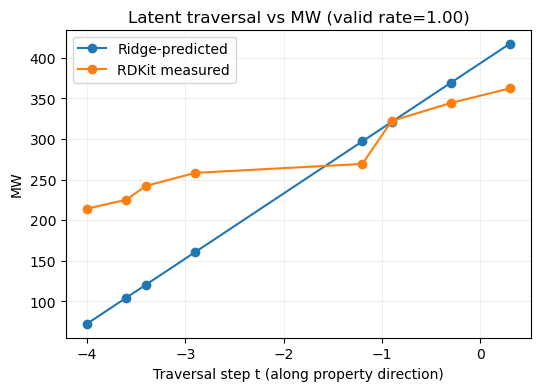

In [11]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

def latent_property_direction(Z, y, alpha=1.0):
    """
    Returns unit direction w in standardized Z space, and standardization stats.
    """
    Zmu = Z.mean(0, keepdims=True)
    Zsd = Z.std(0, keepdims=True) + 1e-8
    Zs = (Z - Zmu) / Zsd

    reg = Ridge(alpha=alpha)
    reg.fit(Zs, y)

    w = reg.coef_.astype(np.float32)
    w = w / (np.linalg.norm(w) + 1e-8)
    return w, Zmu, Zsd, reg

# ---- choose property to demonstrate ----
prop_name = "MW"   # try "TPSA", "MW"
y = props_ok[prop_name].values.astype(np.float32)

w, Zmu, Zsd, reg = latent_property_direction(Z_ok, y, alpha=1.0)

# ---- choose anchor molecule (median property is a good default) ----
mid_idx = int(np.argsort(y)[len(y)//2])
z0 = Z_ok[mid_idx].copy()
s0 = smiles_ok[mid_idx]
print("Anchor SMILES:", s0)
print("Anchor", prop_name, "=", y[mid_idx])

# %%%%%%%%%%%%%%%%%%%%%%%---- traverse ----%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ts = np.array([-4.0, -3.6, -3.4, -2.9, -1.2, -0.9, -0.3, 0.3])# np.linspace(-4.0, 1.0, 50)   # adjust range if needed
decoded = []
preds = []
measured = []

for t in ts:
    z0s = (z0 - Zmu.ravel()) / Zsd.ravel()
    z_new_s = z0s + t * w
    z_new = z_new_s * Zsd.ravel() + Zmu.ravel()

    tok = decode_from_z_greedy(m, z_new, max_len=cfg["seq_length"])[0]
    smi = token_ids_to_smiles(tok, idx_to_token, eos_idx=token_to_idx["<EOS>"], pad_idx=token_to_idx["<PAD>"], sos_idx=token_to_idx["<SOS>"])
    decoded.append(smi)

    pred = reg.predict(((z_new[None, :] - Zmu) / Zsd))[0]
    preds.append(float(pred))

    d = props_from_smiles(smi)
    measured.append(d[prop_name] if d is not None else np.nan)

print("Decoded SMILES (first 5):", decoded[:5])

# ---- plot property vs traversal ----
valid = np.isfinite(measured)
valid_rate = valid.mean()

plt.figure(figsize=(6,4))
plt.plot(ts, preds, marker="o", label="Ridge-predicted")
plt.plot(ts, measured, marker="o", label="RDKit measured")
plt.xlabel("Traversal step t (along property direction)")
plt.ylabel(prop_name)
plt.title(f"Latent traversal vs {prop_name} (valid rate={valid_rate:.2f})")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

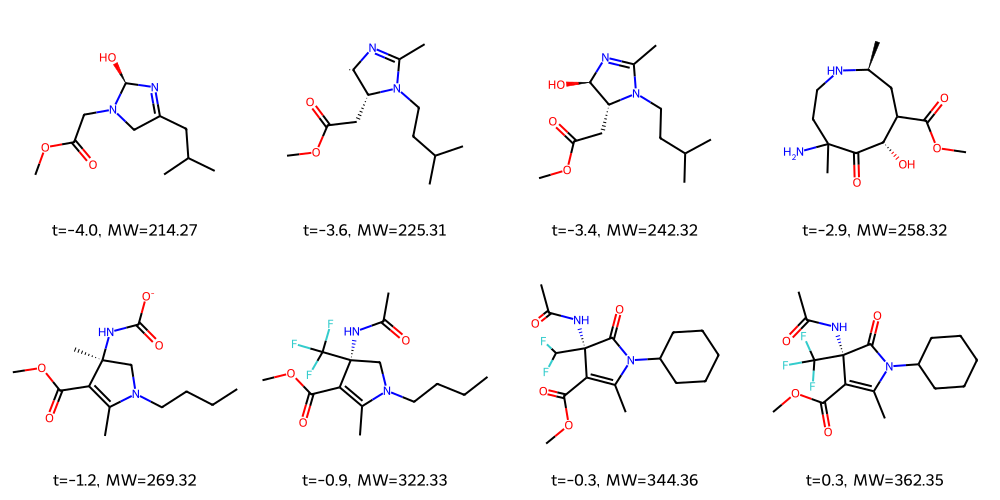

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import math

def draw_valid_traversal_grid(decoded, ts, measured, prop_name, max_per_row=6, subImgSize=(250, 250)):
    """
    decoded: list[str] SMILES in traversal order
    ts: array-like traversal positions (same length as decoded)
    measured: list[float/np.nan] measured property (same length)
    Keeps only valid molecules, preserves order, and auto-chooses grid size
    with no empty slots.
    """
    mols_valid = []
    legends_valid = []

    for smi, t, val in zip(decoded, ts, measured):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue  # skip invalid -> no blank slot

        mols_valid.append(mol)
        if val is None or (isinstance(val, float) and not np.isfinite(val)):
            legends_valid.append(f"t={t:.1f}, INVALID {prop_name}")
        else:
            legends_valid.append(f"t={t:.1f}, {prop_name}={val:.2f}")

    n = len(mols_valid)
    if n == 0:
        print("No valid molecules to plot.")
        return None

    # Choose molsPerRow so that grid is compact and has NO empty slots
    # Strategy: use up to max_per_row, but if fewer molecules, just use n
    molsPerRow = min(max_per_row, n)

    # If you want a more square-ish grid, uncomment:
    # molsPerRow = min(max_per_row, int(math.ceil(math.sqrt(n))))

    img = Draw.MolsToGridImage( mols_valid, molsPerRow=molsPerRow, legends=legends_valid, subImgSize=subImgSize )
    return img

# ---- Use it like this ----
img = draw_valid_traversal_grid(decoded, ts, measured, prop_name, max_per_row=4)  # 3 gives 2 rows for ~6
img